#### Download, extract and copy the mash executable file to ./mash

In [ ]:
!wget https://github.com/marbl/Mash/releases/download/v2.2/mash-Linux64-v2.2.tar

In [ ]:
!tar -xf mash-Linux64-v2.2.tar

In [9]:
!cp mash-Linux64-v2.2/mash .
!rm -rf mash-Linux64-v2.2.tar mash-Linux64-v2.2

#### Benchmark

In [21]:
%run ../../multibench.py

In [22]:
import sys
import os
import shutil
import numpy as np
import glob

# Move two upper directories, import benchmark, revert cwd
sys.path.append("../..")
import cmdbench
sys.path.pop()

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

input_dir = 'input/'
input_samples = glob.glob(input_dir + '*.fastq.gz')
print(input_samples)

['input/2014C-3655_2.fastq.gz', 'input/2014C-3907_2.fastq.gz', 'input/2014C-3599_1.fastq.gz', 'input/2014C-3656_1.fastq.gz', 'input/2014C-3598_2.fastq.gz', 'input/2014C-3840_1.fastq.gz', 'input/2014C-3655_1.fastq.gz', 'input/2014C-3599_2.fastq.gz', 'input/2014C-3857_2.fastq.gz', 'input/2014C-3598_1.fastq.gz', 'input/2014C-3850_1.fastq.gz', 'input/2014C-3840_2.fastq.gz', 'input/2014C-3857_1.fastq.gz', 'input/2014C-3656_2.fastq.gz', 'input/2014C-3907_1.fastq.gz', 'input/2014C-3850_2.fastq.gz', 'input/2014C-3600_2.fastq.gz', 'input/2014C-3600_1.fastq.gz']


In [23]:
def clean_if_exists(path):
    if os.path.exists(path):
        if(os.path.isfile(path)):
            os.remove(path)
        else:
            shutil.rmtree(path)
            os.mkdir(path)
def get_last_n_lines(string, n):
    return "\n".join(string.split("\n")[-n:])

In [24]:
%%bash
# You might need to run this before starting jupyter notebook in your shell
export BIGSI_CONFIG=berkleydb.yaml

In [25]:
sample_sizes = list(range(1, 18 + 1))
print(sample_sizes)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [26]:
def reset_func():
    # It's already being done in the get_sketching_command function but just
    # in case we change that function
    clean_if_exists("sketches.msh")
    pass
    
def benchmark_list_to_results(benchmark_firsts_list):
    return {
        "memory": max(list(map(lambda result: result.memory.max, benchmark_firsts_list))),
        "disk_read": max(list(map(lambda result: result.disk.read_chars, benchmark_firsts_list))),
        "disk_write": max(list(map(lambda result: result.disk.write_chars, benchmark_firsts_list))),
        "runtime": sum(list(map(lambda result: result.process.execution_time, benchmark_firsts_list)))
    }
def sampling_func(sample_size):
    samples = input_samples[:sample_size]
    return samples

sketching_command_run_count = 25

def get_sketching_command(inputs):
    clean_if_exists("sketches.msh")
    return "./mash sketch -o sketches.msh " + " ".join(inputs)
    
build_command = {
    "use_parallel": True,
    "command": get_sketching_command,
    "parallel_args": "-j 1 -N0 ",
    "parallel_argfiles": ["_"] * sketching_command_run_count
}

dist_calculation_times = 25
dist_calculating_genome = "2014C-3600_1.fastq.gz"

query_command = {
    "command": "./mash dist sketches.msh input/% ",
    "parallel_args": "-j 1 -I%",
    "parallel_argfiles": [dist_calculating_genome] * dist_calculation_times
}

multibench_results, debug_str = multi_cmdbench({
"index": [build_command],
"query": [query_command]
}, reset_func = reset_func, iterations = 10, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results=benchmark_list_to_results)

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

[{'memory': 27547238.4, 'disk_read': 5230126.4, 'disk_write': 2141320.2, 'runtime': 0.339}, {'memory': 28541747.2, 'disk_read': 8296825.6, 'disk_write': 2403010.4, 'runtime': 0.5269999999999999}, {'memory': 27395276.8, 'disk_read': 12275415.2, 'disk_write': 2655613.2, 'runtime': 0.7909999999999999}, {'memory': 28261171.2, 'disk_read': 14573720.1, 'disk_write': 2880597.9, 'runtime': 0.942}, {'memory': 27587788.8, 'disk_read': 19451161.9, 'disk_write': 3113794.5, 'runtime': 1.2359999999999998}, {'memory': 28290662.4, 'disk_read': 21845888.5, 'disk_write': 3332073.9, 'runtime': 1.3909999999999998}, {'memory': 27235532.8, 'disk_read': 24518233.0, 'disk_write': 3546979.4, 'runtime': 1.5630000000000002}, {'memory': 27254784.0, 'disk_read': 29353895.7, 'disk_write': 3766714.3, 'runtime': 1.8219999999999998}, {'memory': 28532736.0, 'disk_read': 32177450.0, 'disk_write': 3980013.3, 'runtime': 1.996}, {'memory': 27008204.8, 'disk_read': 36200594.4, 'disk_write': 4199226.1, 'runtime': 2.269}, {'m

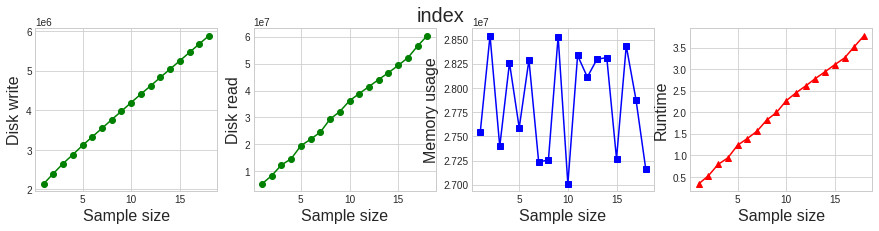

In [28]:
# Indexing Plots
plot_resources(multibench_results, sample_sizes, "index")

[{'memory': 27135590.4, 'disk_read': 6138283.7, 'disk_write': 1968870.6, 'runtime': 0.42200000000000004}, {'memory': 28184576.0, 'disk_read': 6140256.2, 'disk_write': 1973879.4, 'runtime': 0.43000000000000005}, {'memory': 27974041.6, 'disk_read': 6142384.7, 'disk_write': 1977311.7, 'runtime': 0.42600000000000005}, {'memory': 28488499.2, 'disk_read': 6145301.1, 'disk_write': 1983446.8, 'runtime': 0.42400000000000004}, {'memory': 26486374.4, 'disk_read': 6147390.6, 'disk_write': 1989384.9, 'runtime': 0.43599999999999994}, {'memory': 28187852.8, 'disk_read': 6149700.5, 'disk_write': 1989521.2, 'runtime': 0.425}, {'memory': 28366848.0, 'disk_read': 6150859.3, 'disk_write': 1993541.4, 'runtime': 0.429}, {'memory': 28545433.6, 'disk_read': 6152938.8, 'disk_write': 1999464.3, 'runtime': 0.425}, {'memory': 28523315.2, 'disk_read': 6155582.3, 'disk_write': 2002982.6, 'runtime': 0.42600000000000005}, {'memory': 27226931.2, 'disk_read': 6157695.5, 'disk_write': 2008866.6, 'runtime': 0.429}, {'mem

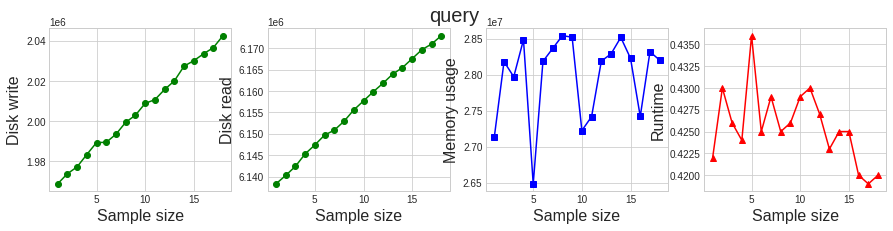

In [29]:
# Querying Plots
plot_resources(multibench_results, sample_sizes, "query")